In [1]:
#libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#my libraries
import prepare
import acquire
import env

#library imports
from datetime import date
from sklearn.model_selection import train_test_split

In [2]:
df = acquire.get_zillow_data()
df.head(2)

,bathroomcnt,bedroomcnt,fips,yearbuilt,taxvaluedollarcnt,taxamount,calculatedfinishedsquarefeet,log_error
0,2.0,3.0,6037.0,1923.0,205123.0,2627.48,1316.0,0.017785
1,2.0,3.0,6037.0,1970.0,136104.0,2319.90,1458.0,-0.362001


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28124 entries, 0 to 28123
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bathroomcnt                   28124 non-null  float64
 1   bedroomcnt                    28124 non-null  float64
 2   fips                          28124 non-null  float64
 3   yearbuilt                     28053 non-null  float64
 4   taxvaluedollarcnt             28123 non-null  float64
 5   taxamount                     28123 non-null  float64
 6   calculatedfinishedsquarefeet  28077 non-null  float64
 7   log_error                     28124 non-null  float64
dtypes: float64(8)
memory usage: 1.7 MB


In [4]:
df = prepare.clean_data(df)
df.head(2)

,bathrooms,bedrooms,county_code,tax_value,square_feet,log_error,age,tax_rate
0,2,3,6037,205123,1316,0.017785,98,0.012809
1,2,3,6037,136104,1458,-0.362001,51,0.017045


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28124 entries, 0 to 28123
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   bathrooms    28124 non-null  int64  
 1   bedrooms     28124 non-null  int64  
 2   county_code  28124 non-null  int64  
 3   tax_value    28124 non-null  int64  
 4   square_feet  28124 non-null  int64  
 5   log_error    28124 non-null  float64
 6   age          28124 non-null  int64  
 7   tax_rate     28124 non-null  float64
dtypes: float64(2), int64(6)
memory usage: 1.7 MB


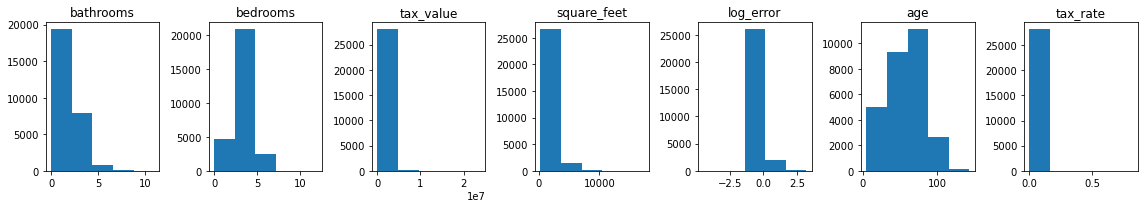

In [6]:
prepare.get_hist(df)

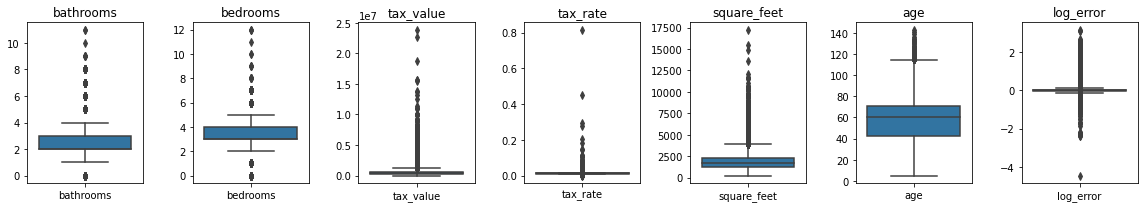

In [7]:
prepare.get_box(df)

In [8]:
df = prepare.remove_outliers(df, k = 1.5 , col_list = ['bathrooms', 'bedrooms', 'tax_value', 'square_feet', 'age', 'log_error'])
df.head()

,bathrooms,bedrooms,county_code,tax_value,square_feet,log_error,age,tax_rate
0,2,3,6037,205123,1316,0.017785,98,0.012809
3,3,4,6059,880456,2541,0.021085,18,0.011153
6,1,2,6037,274237,693,-0.005566,100,0.011915
7,2,4,6037,164269,1655,-0.064447,66,0.013208
10,2,3,6037,286062,1440,-0.026896,83,0.021303


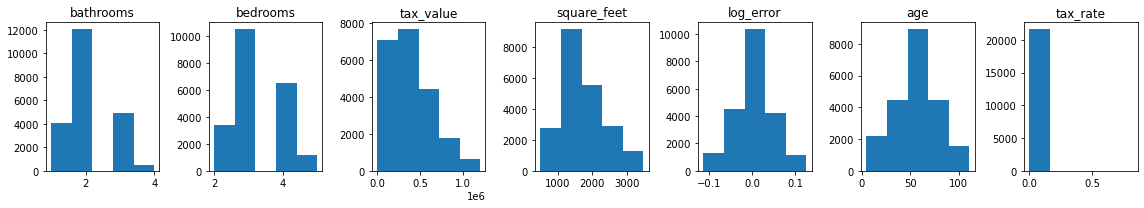

In [9]:
prepare.get_hist(df)

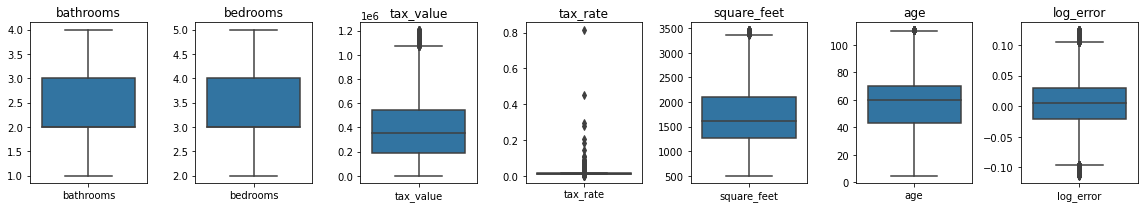

In [10]:
prepare.get_box(df)

In [12]:
train, validate, test = prepare.train_validate_test_split(df)